In [25]:
import os
import rasterio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow_examples.models.pix2pix import pix2pix

In [4]:
images_directory = '/kaggle/input/satellite-cellua/data/images'
labels_directory = '/kaggle/input/satellite-cellua/data/labels'

In [5]:
def load_images_and_labels(image_folder, label_folder):
    images = []
    labels = []
    
    for image_file in os.listdir(image_folder):
        if image_file.endswith('.tif'):
            image_path = os.path.join(image_folder, image_file)
            label_path = os.path.join(label_folder, image_file.replace('.tif', '.png'))
            
            with rasterio.open(image_path) as src:
                image = src.read()  # Shape: (12, 128, 128)
                
                # Transpose to shape (128, 128, 12)
                image = np.transpose(image, (1, 2, 0))
                
            label = np.array(Image.open(label_path))
            
            images.append(image)
            labels.append(label)
            
    
    # Normilization    
    images = np.array(images) / 255.0  
        
    return images, np.array(labels)

In [6]:
images, labels = load_images_and_labels(images_directory, labels_directory)

/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [7]:
def preprocess_labels(labels):
#     return (labels == 1).astype(np.uint8)
    return np.asarray(labels, dtype=np.float32)


labels = preprocess_labels(labels)


In [8]:
def visualize_raw_data(images, labels, num_images=5):
    for i in range(num_images):
        plt.figure(figsize=(10, 10))

        plt.subplot(4, 3, 1)
        rgb_image = np.stack([images[i][:, :, 3], images[i][:, :, 2], images[i][:, :, 1]], axis=-1)  # Red, Green, Blue channels
        rgb_image_normalized = rgb_image / np.max(rgb_image)
        plt.title("RGB Image")
        plt.imshow(rgb_image_normalized)
        plt.axis('off')

        # Display the Coastal Aerosol layer
        plt.subplot(4, 3, 2)
        plt.title("Coastal Aerosol Layer")
        plt.imshow(images[i][:, :, 0], cmap='gray')
        plt.axis('off')

        # Display the Water Occurrence Probability layer
        plt.subplot(4, 3, 3)
        plt.title("Water Occurrence Probability")
        plt.imshow(images[i][:, :, 11], cmap='hot')  # Last channel (index 11)
        plt.axis('off')

        # Display the NIR layer
        plt.subplot(4, 3, 4)
        plt.title("NIR Layer")
        plt.imshow(images[i][:, :, 4], cmap='gray')
        plt.axis('off')

        # Display the SWIR1 layer
        plt.subplot(4, 3, 5)
        plt.title("SWIR1 Layer")
        plt.imshow(images[i][:, :, 5], cmap='gray')
        plt.axis('off')

        # Display the SWIR2 layer
        plt.subplot(4, 3, 6)
        plt.title("SWIR2 Layer")
        plt.imshow(images[i][:, :, 6], cmap='gray')
        plt.axis('off')

        # Display the QA Band layer
        plt.subplot(4, 3, 7)
        plt.title("QA Band Layer")
        plt.imshow(images[i][:, :, 7], cmap='gray')
        plt.axis('off')

        # Display the Merit DEM layer
        plt.subplot(4, 3, 8)
        plt.title("Merit DEM Layer")
        plt.imshow(images[i][:, :, 8], cmap='gray')
        plt.axis('off')

        # Display the Copernicus DEM layer
        plt.subplot(4, 3, 9)
        plt.title("Copernicus DEM Layer")
        plt.imshow(images[i][:, :, 9], cmap='gray')
        plt.axis('off')

        # Display the ESA World Cover Map layer
        plt.subplot(4, 3, 10)
        plt.title("ESA World Cover Map")
        plt.imshow(images[i][:, :, 10], cmap='gray')
        plt.axis('off')

        # Display the Ground Truth label
        plt.subplot(4, 3, 11)
        plt.title("Ground Truth")
        plt.imshow(labels[i], cmap='gray')
        plt.axis('off')

        plt.show()



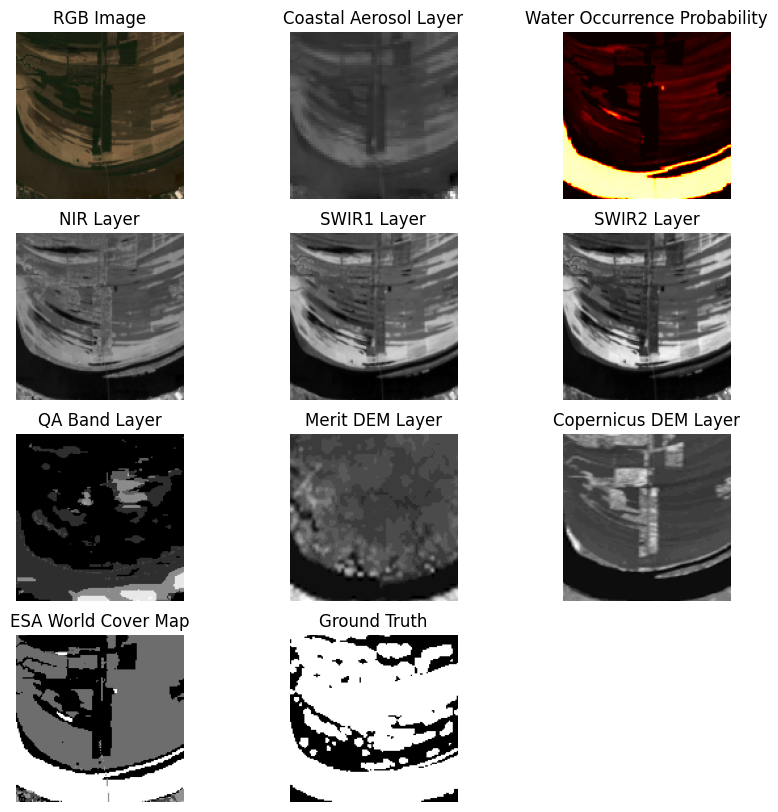

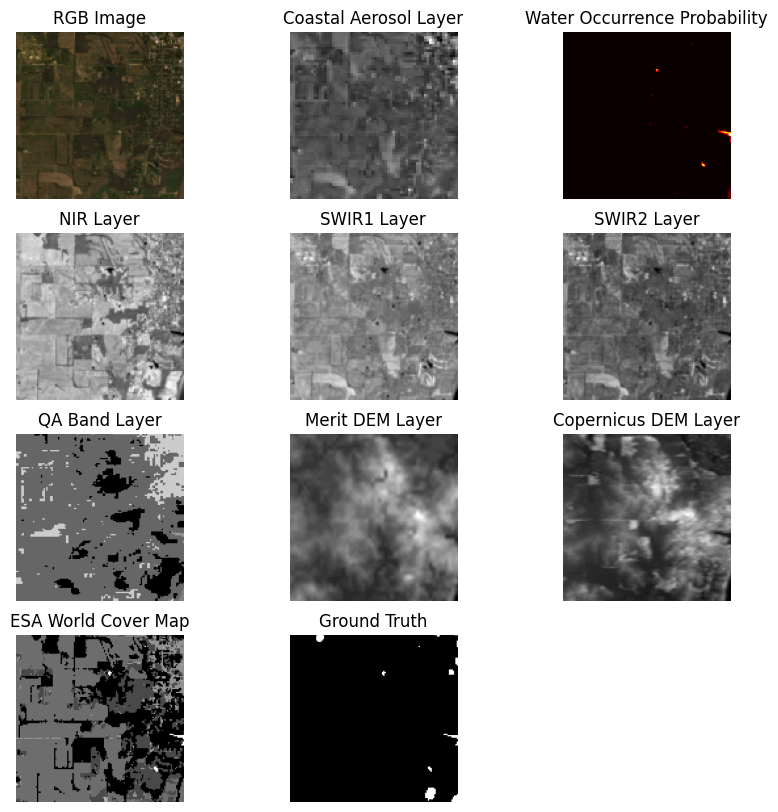

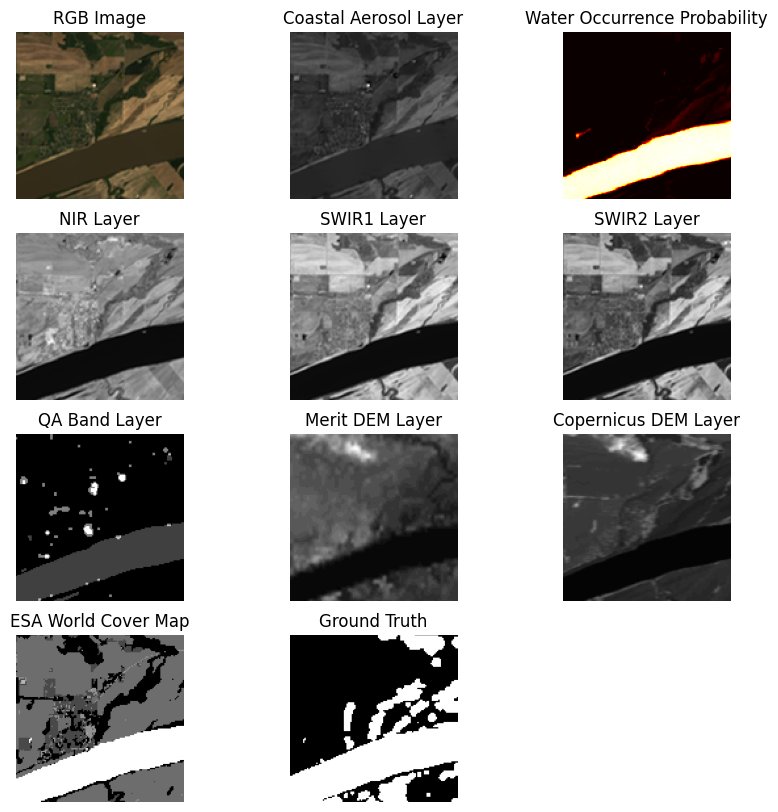

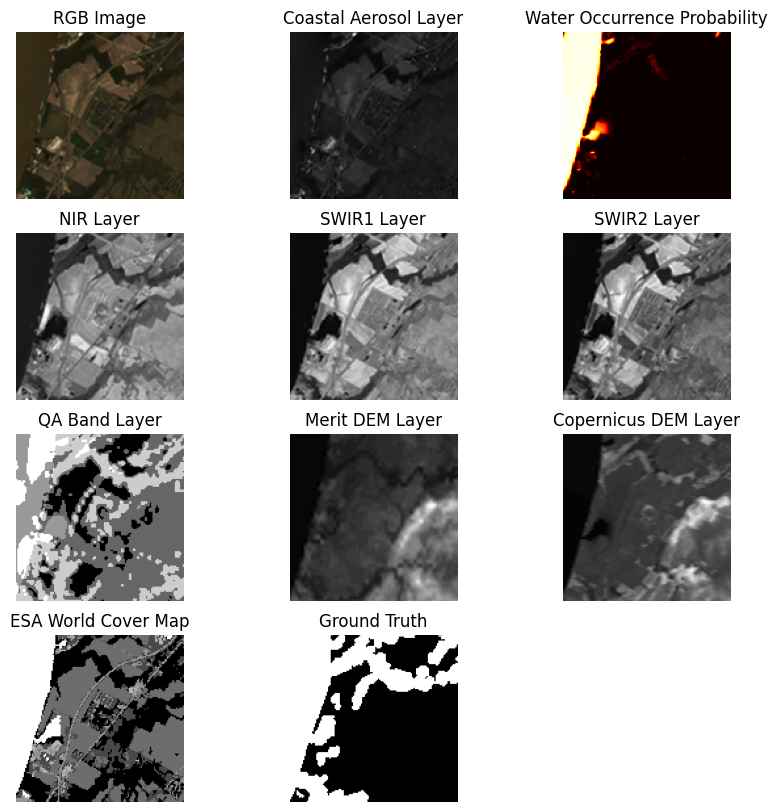

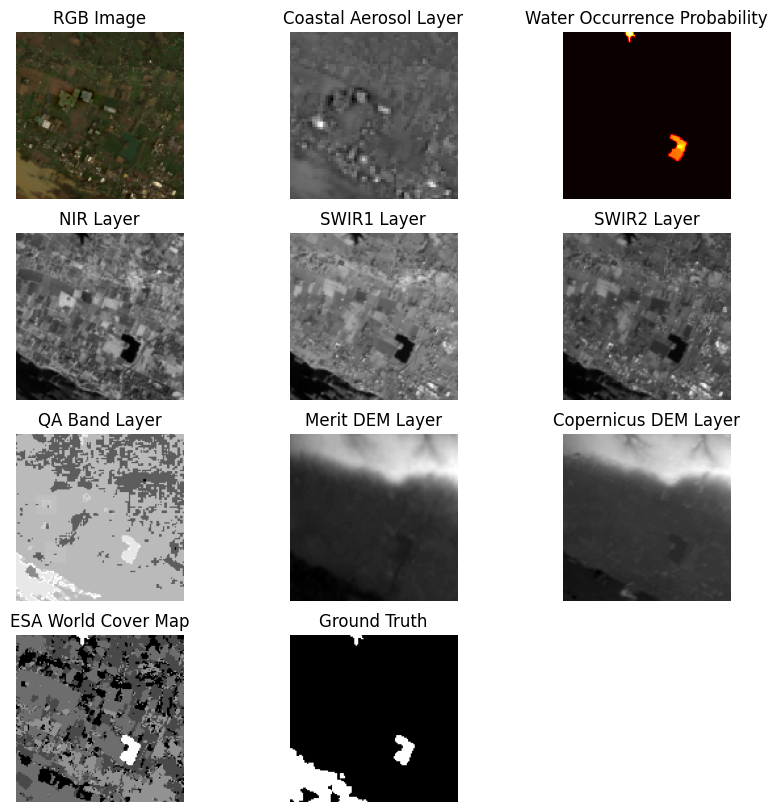

In [9]:
visualize_raw_data(images, labels)

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [93]:
def visualize_predictions(model, X_test, y_test, num_images=5):
    predictions = model.predict(X_test)
    
    for i in range(num_images):
        plt.figure(figsize=(10, 10))

#         plt.subplot(1, 3, 1)
#         plt.title("Input Image")
#         plt.imshow(X_test[i][:, :, 2], cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(y_test[-i], cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(predictions[-i] > 0.5, cmap='gray')

        plt.show()

In [12]:
def iou_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred > 0.5, 'float32')  # For binary classification, thresholding at 0.5
    
    # Flatten the tensors to ensure the shapes match
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(K.abs(y_true) + K.abs(y_pred)) - intersection
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    
    return iou


In [13]:
def precision_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred > 0.5, 'float32')
    
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    true_positives = K.sum(y_true * y_pred)
    predicted_positives = K.sum(y_pred)
    precision = true_positives / (predicted_positives + K.epsilon())
    
    return precision

def recall_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred > 0.5, 'float32')
    
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    true_positives = K.sum(y_true * y_pred)
    actual_positives = K.sum(y_true)
    recall = true_positives / (actual_positives + K.epsilon())
    
    return recall

def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1


In [77]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

def preprocess_images(X, selected_channels=[1, 2, 3], target_size=(128, 128)):

    num_samples = X.shape[0]
    preprocessed_images = np.zeros((num_samples, target_size[0], target_size[1], 3), dtype=np.float32)

    for i in range(num_samples):
        image = X[i]
        selected_image = image[:, :, selected_channels]
        
        selected_image = selected_image / np.max(selected_image)
        
        resized_image = tf.image.resize(selected_image, target_size).numpy()
        
        preprocessed_images[i] = resized_image
    
    return preprocessed_images


X_train_preprocessed = preprocess_images(X_train)
X_val_preprocessed = preprocess_images(X_val)

print(X_train_preprocessed.shape) 

(214, 128, 128, 3)


In [90]:
def create_deep_lab_model(input_shape):
    base_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape)

    inputs = tf.keras.Input(shape=input_shape)
    
    x = base_model(inputs, training=False)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    
    x = tf.keras.layers.UpSampling2D(size=(32, 32), interpolation='bilinear')(x)
    
    model = tf.keras.Model(inputs, x)
    model.compile(optimizer='adam', loss="binary_crossentropy", 
                  metrics=['accuracy',iou_metric,precision_metric, recall_metric, f1_metric]
                 )
    return model


model = create_deep_lab_model(input_shape=(128, 128, 3))

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_54 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 4, 4, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 4, 4, 64)       │     1,105,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 4, 4, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 4, 4, 1)        │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_14 (UpSampling2D) │ (None, 128, 128, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,483,393 (74.32 MB)

 Trainable params: 19,254,337 (73.45 MB)

 Non-trainable params: 229,056 (894.75 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


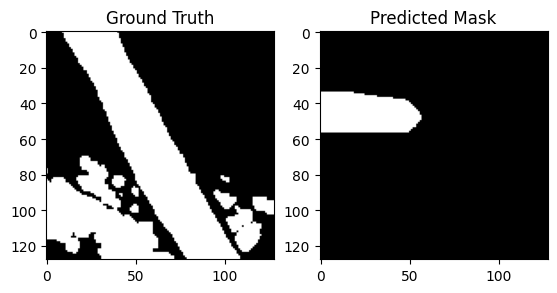

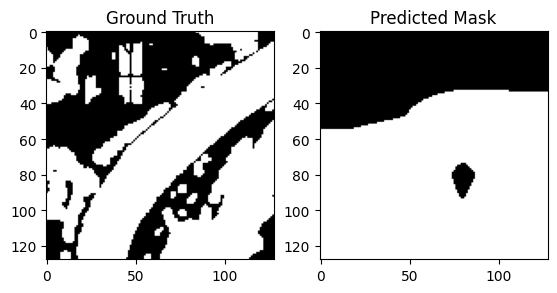

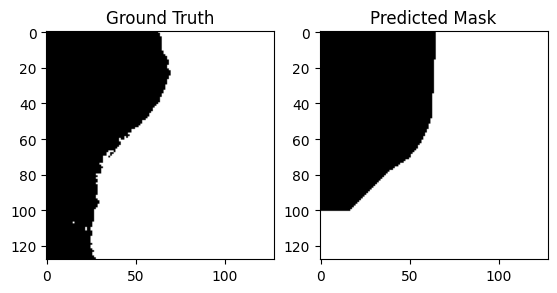

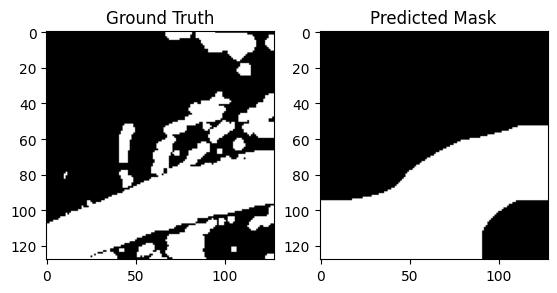

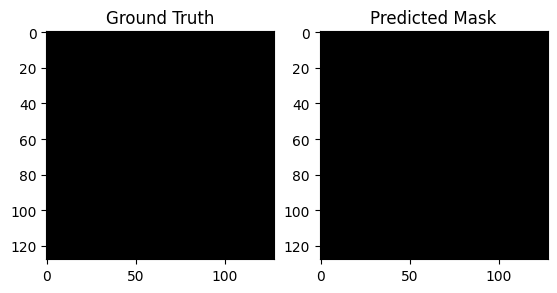

In [94]:
X_test_preprocessed = preprocess_images(X_test)

visualize_predictions(model, X_test_preprocessed, y_test)

In [91]:
model_history = model.fit(X_train_preprocessed, y_train, epochs=50, batch_size=16,validation_data=(X_val_preprocessed,y_val))

Epoch 1/50


I0000 00:00:1726153718.330897     237 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_66', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_935', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_57', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_754', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_750', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_747', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_746', 4 bytes spill stores

14/14 ━━━━━━━━━━━━━━━━━━━━ 355s 10s/step - accuracy: 0.7617 - f1_metric: 0.3303 - iou_metric: 0.2236 - loss: 0.5787 - precision_metric: 0.4693 - recall_metric: 0.2976 - val_accuracy: 0.5255 - val_f1_metric: 0.4000 - val_iou_metric: 0.2545 - val_loss: 1.6475 - val_precision_metric: 0.3104 - val_recall_metric: 0.5789
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.8016 - f1_metric: 0.5084 - iou_metric: 0.3540 - loss: 0.4466 - precision_metric: 0.6612 - recall_metric: 0.4312 - val_accuracy: 0.7088 - val_f1_metric: 0.0179 - val_iou_metric: 0.0091 - val_loss: 1.7830 - val_precision_metric: 0.0875 - val_recall_metric: 0.0100
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.8493 - f1_metric: 0.6467 - iou_metric: 0.4831 - loss: 0.3694 - precision_metric: 0.7436 - recall_metric: 0.5937 - val_accuracy: 0.6077 - val_f1_metric: 0.3551 - val_iou_metric: 0.2234 - val_loss: 2.7500 - val_precision_metric: 0.3206 - val_recall_metric: 0.4018
Epoch 4/50
14/14 ━━━━━━━━━━

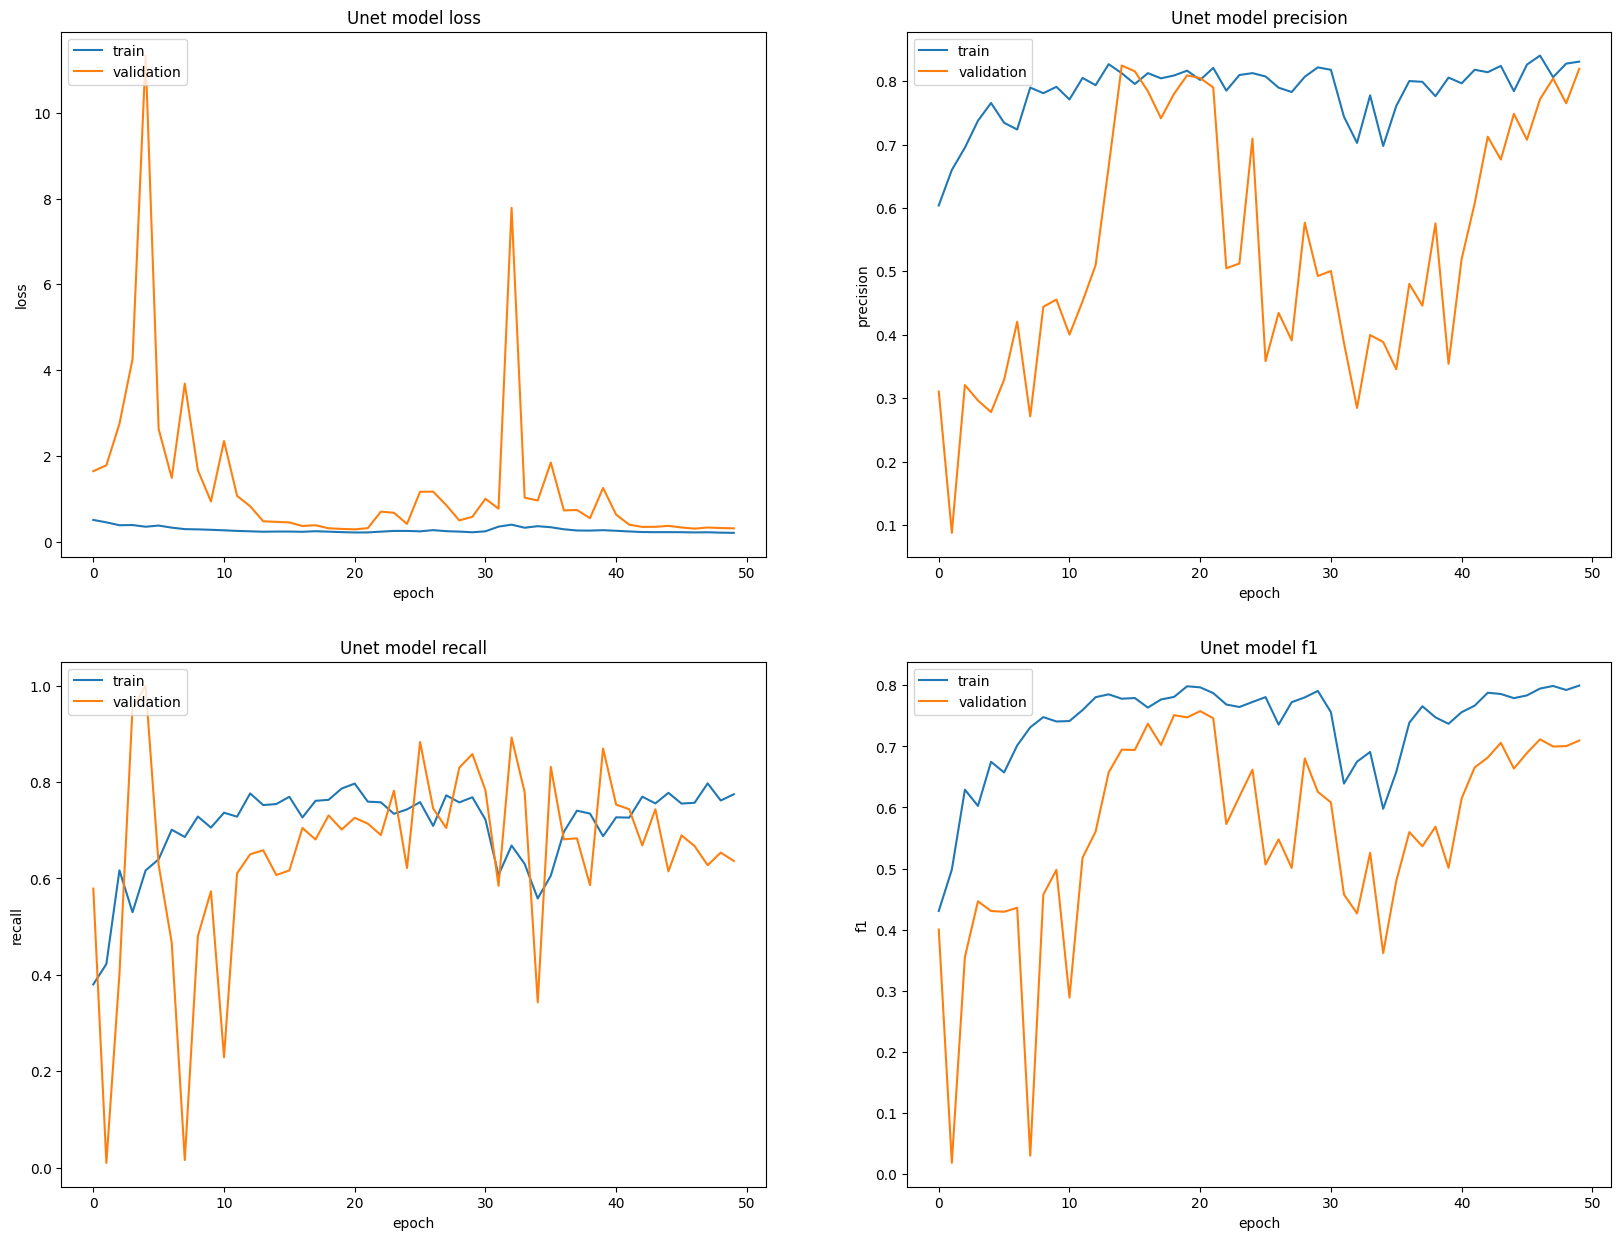

In [96]:
fig,((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(20,15))
ax11.plot(model_history.history['loss'])
ax11.plot(model_history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(model_history.history['precision_metric'])
ax12.plot(model_history.history['val_precision_metric'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(model_history.history['recall_metric'])
ax13.plot(model_history.history['val_recall_metric'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(model_history.history['f1_metric'])
ax14.plot(model_history.history['val_f1_metric'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')